In [ ]:
pip install transformers datasets peft accelerate py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1

In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType

# Load the SamSum dataset
dataset = load_dataset("samsum")

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Preprocess the dataset: Tokenizing the data and adding labels
def preprocess_function(examples):
    inputs = tokenizer(examples["dialogue"], truncation=True, padding="max_length", max_length=512)
    # Example criterion: label 1 if dialogue length > 100 words, else label 0
    inputs["labels"] = [1 if len(dialogue.split()) > 100 else 0 for dialogue in examples["dialogue"]]
    return inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

# Configuration for LoRA fine-tuning
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification task
    r=16,  # Rank of the update matrices
    lora_alpha=32,  # Alpha scaling factor
    lora_dropout=0.1,  # Dropout rate for LoRA
    bias="none"  # Bias strategy for LoRA
)

# Apply LoRA to the model
lora_model = get_peft_model(model, lora_config)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    save_steps=500
)

# Trainer setup
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer
)

# Fine-tuning the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./finetuned_roberta_samsum_lora")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.120900,0.073764
2,0.097900,0.056194
3,0.049200,0.049774


In [ ]:
!zip -r /content/roberta_ft.zip /content/finetuned_roberta_samsum_lora

  adding: content/finetuned_roberta_samsum_lora/ (stored 0%)
  adding: content/finetuned_roberta_samsum_lora/adapter_model.safetensors (deflated 7%)
  adding: content/finetuned_roberta_samsum_lora/adapter_config.json (deflated 52%)
  adding: content/finetuned_roberta_samsum_lora/vocab.json (deflated 68%)
  adding: content/finetuned_roberta_samsum_lora/README.md (deflated 66%)
  adding: content/finetuned_roberta_samsum_lora/tokenizer_config.json (deflated 76%)
  adding: content/finetuned_roberta_samsum_lora/special_tokens_map.json (deflated 84%)
  adding: content/finetuned_roberta_samsum_lora/merges.txt (deflated 53%)
  adding: content/finetuned_roberta_samsum_lora/training_args.bin (deflated 51%)


In [ ]:
from google.colab import files
files.download("/content/roberta_ft.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from peft import PeftModel
import evaluate

# Load the SamSum dataset
dataset = load_dataset("samsum")

# Preprocess the dataset (ensure it's the same preprocessing function used before)
def preprocess_function(examples):
    inputs = tokenizer(examples["dialogue"], truncation=True, padding="max_length", max_length=512)
    inputs["labels"] = [1 if len(dialogue.split()) > 100 else 0 for dialogue in examples["dialogue"]]
    return inputs

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the validation dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)
validation_dataset = tokenized_datasets["validation"]

# Evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Helper function to evaluate a model
def evaluate_model(model, tokenizer, dataset):
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer
    )

    # Get predictions
    predictions = trainer.predict(dataset)

    # Extract predicted labels and true labels
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=-1)
    labels = torch.tensor(predictions.label_ids)

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_score = f1_metric.compute(predictions=preds, references=labels, average="weighted")

    return accuracy, f1_score

# -----------------------------------------------
# 1. Evaluate the base RoBERTa model
# -----------------------------------------------
print("Evaluating Base RoBERTa Model...")

# Load the base RoBERTa model
base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Evaluate the base model
base_accuracy, base_f1 = evaluate_model(base_model, tokenizer, validation_dataset)

print(f"Base Model Accuracy: {base_accuracy['accuracy']:.4f}")
print(f"Base Model F1 Score: {base_f1['f1']:.4f}")

# -----------------------------------------------
# 2. Evaluate the Fine-Tuned RoBERTa model
# -----------------------------------------------
print("\nEvaluating Fine-Tuned RoBERTa Model...")

# Load the fine-tuned RoBERTa model with LoRA
fine_tuned_model = RobertaForSequenceClassification.from_pretrained("./finetuned_roberta_samsum_lora")
fine_tuned_model = PeftModel.from_pretrained(fine_tuned_model, "./finetuned_roberta_samsum_lora")

# Evaluate the fine-tuned model
fine_tuned_accuracy, fine_tuned_f1 = evaluate_model(fine_tuned_model, tokenizer, validation_dataset)

print(f"Fine-Tuned Model Accuracy: {fine_tuned_accuracy['accuracy']:.4f}")
print(f"Fine-Tuned Model F1 Score: {fine_tuned_f1['f1']:.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Evaluating Base RoBERTa Model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base Model Accuracy: 0.3411
Base Model F1 Score: 0.1735

Evaluating Fine-Tuned RoBERTa Model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-Tuned Model Accuracy: 0.9829
Fine-Tuned Model F1 Score: 0.9829


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer
from peft import PeftModel
import evaluate

# Load the pruned model with LoRA (replace with your model path)
model = RobertaForSequenceClassification.from_pretrained("./finetuned_roberta_samsum_lora")
model = PeftModel.from_pretrained(model, "./finetuned_roberta_samsum_lora")

# Function to prune LoRA weights (as defined before)
def prune_lora_weights(model, percentage=0.5):
    for n, m in model.named_modules():
        if isinstance(m, torch.nn.Linear) and "lora" in n:
            weight = m.weight.data
            num_weights_to_prune = int(weight.numel() * percentage)
            # _, indices = torch.topk(torch.abs(weight).view(-1), num_weights_to_prune, largest=False)
            indices = torch.randperm(weight.numel())[:num_weights_to_prune]
            weight.view(-1)[indices] = 0

# Prune the model weights (e.g., 50% sparsity)
prune_lora_weights(model, percentage=0.5)

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Load the Samsum dataset
dataset = load_dataset("samsum")

# Preprocess the dataset (ensure it's the same preprocessing function used before)
def preprocess_function(examples):
    inputs = tokenizer(examples["dialogue"], truncation=True, padding="max_length", max_length=512)
    inputs["labels"] = [1 if len(dialogue.split()) > 100 else 0 for dialogue in examples["dialogue"]]
    return inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)
validation_dataset = tokenized_datasets["validation"]

# Evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Helper function to evaluate a model (same as before)
def evaluate_model(model, tokenizer, dataset):
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer
    )
    predictions = trainer.predict(dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=-1)
    labels = torch.tensor(predictions.label_ids)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_score = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return accuracy, f1_score

# Evaluate the pruned model
pruned_accuracy, pruned_f1 = evaluate_model(model, tokenizer, validation_dataset)

print(f"Pruned Model Accuracy: {pruned_accuracy['accuracy']:.4f}")
print(f"Pruned Model F1 Score: {pruned_f1['f1']:.4f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Pruned Model Accuracy: 0.6760
Pruned Model F1 Score: 0.5615


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Pruned Model (10% sparsity) - Accuracy: 0.9756, F1: 0.9756


Pruned Model (20% sparsity) - Accuracy: 0.9621, F1: 0.9623


Pruned Model (30% sparsity) - Accuracy: 0.9340, F1: 0.9331


Pruned Model (40% sparsity) - Accuracy: 0.8252, F1: 0.8086


Pruned Model (50% sparsity) - Accuracy: 0.7225, F1: 0.6515


Pruned Model (60% sparsity) - Accuracy: 0.6687, F1: 0.5456


Pruned Model (70% sparsity) - Accuracy: 0.6589, F1: 0.5234


Pruned Model (80% sparsity) - Accuracy: 0.6589, F1: 0.5234


Pruned Model (90% sparsity) - Accuracy: 0.6589, F1: 0.5234


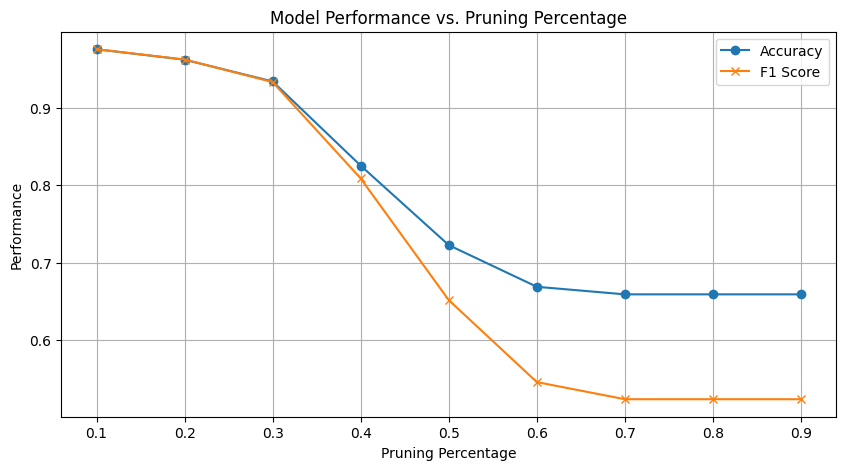

In [ ]:
import torch
import copy
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer
from peft import PeftModel
import evaluate
import matplotlib.pyplot as plt

# Load the fine-tuned model with LoRA
model = RobertaForSequenceClassification.from_pretrained("./finetuned_roberta_samsum_lora")
model = PeftModel.from_pretrained(model, "./finetuned_roberta_samsum_lora")

# Function to prune LoRA weights randomly
def prune_lora_weights_randomly(model, percentage=0.5):
    for n, m in model.named_modules():
        if isinstance(m, torch.nn.Linear) and "lora" in n:
            weight = m.weight.data
            num_weights_to_prune = int(weight.numel() * percentage)
            indices = torch.randperm(weight.numel())[:num_weights_to_prune]
            weight.view(-1)[indices] = 0

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Load the Samsum dataset
dataset = load_dataset("samsum")

# Preprocess the dataset
def preprocess_function(examples):
    inputs = tokenizer(examples["dialogue"], truncation=True, padding="max_length", max_length=512)
    inputs["labels"] = [1 if len(dialogue.split()) > 100 else 0 for dialogue in examples["dialogue"]]
    return inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)
validation_dataset = tokenized_datasets["validation"]

# Evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Helper function to evaluate a model
def evaluate_model(model, tokenizer, dataset):
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer
    )
    predictions = trainer.predict(dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=-1)
    labels = torch.tensor(predictions.label_ids)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_score = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return accuracy, f1_score

# Store results for plotting
accuracies = []
f1_scores = []

# Pruning percentages to test
pruning_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for percentage in pruning_percentages:
    # Create a copy of the model
    pruned_model = copy.deepcopy(model)

    # Prune the copied model weights
    prune_lora_weights_randomly(pruned_model, percentage)

    # Evaluate the pruned model
    pruned_accuracy, pruned_f1 = evaluate_model(pruned_model, tokenizer, validation_dataset)

    print(f"Pruned Model ({percentage*100:.0f}% sparsity) - Accuracy: {pruned_accuracy['accuracy']:.4f}, F1: {pruned_f1['f1']:.4f}")

    accuracies.append(pruned_accuracy['accuracy'])
    f1_scores.append(pruned_f1['f1'])

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(pruning_percentages, accuracies, marker='o', label="Accuracy")
plt.plot(pruning_percentages, f1_scores, marker='x', label="F1 Score")
plt.xlabel("Pruning Percentage")
plt.ylabel("Performance")
plt.title("Model Performance vs. Pruning Percentage")
plt.legend()
plt.grid(True)
plt.show()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total fine-tuning parameters: 589824


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Pruned Model (10% sparsity) - Accuracy: 0.9829, F1: 0.9829


Pruned Model (20% sparsity) - Accuracy: 0.9853, F1: 0.9853


Pruned Model (30% sparsity) - Accuracy: 0.9841, F1: 0.9841


Pruned Model (40% sparsity) - Accuracy: 0.9804, F1: 0.9805


Pruned Model (50% sparsity) - Accuracy: 0.9756, F1: 0.9756


Pruned Model (60% sparsity) - Accuracy: 0.9633, F1: 0.9636


Pruned Model (70% sparsity) - Accuracy: 0.9487, F1: 0.9489


Pruned Model (80% sparsity) - Accuracy: 0.8557, F1: 0.8464


Pruned Model (90% sparsity) - Accuracy: 0.6663, F1: 0.5401


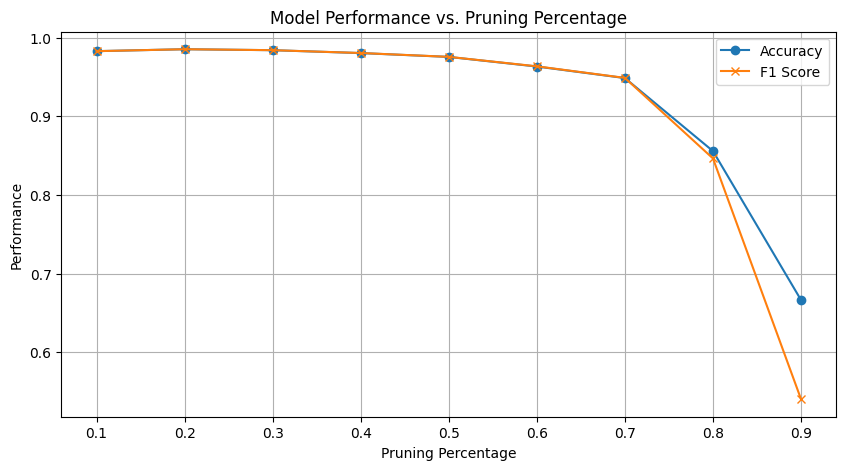

In [ ]:
import torch
import copy
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer
from peft import PeftModel
import evaluate
import matplotlib.pyplot as plt

# Load the fine-tuned model with LoRA
model = RobertaForSequenceClassification.from_pretrained("./finetuned_roberta_samsum_lora")
model = PeftModel.from_pretrained(model, "./finetuned_roberta_samsum_lora")

# Calculate the number of fine-tuning parameters
total_lora_params = sum(p.numel() for n, p in model.named_parameters() if 'lora' in n)
print(f"Total fine-tuning parameters: {total_lora_params}")

# Function to prune LoRA weights randomly
def prune_lora_weights_randomly(model, percentage=0.5):
    for n, m in model.named_modules():
        if isinstance(m, torch.nn.Linear) and "lora" in n:
            weight = m.weight.data
            num_weights_to_prune = int(weight.numel() * percentage)
            _, indices = torch.topk(torch.abs(weight).view(-1), num_weights_to_prune, largest=False)
            weight.view(-1)[indices] = 0

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Load the Samsum dataset
dataset = load_dataset("samsum")

# Preprocess the dataset
def preprocess_function(examples):
    inputs = tokenizer(examples["dialogue"], truncation=True, padding="max_length", max_length=512)
    inputs["labels"] = [1 if len(dialogue.split()) > 100 else 0 for dialogue in examples["dialogue"]]
    return inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)
validation_dataset = tokenized_datasets["validation"]

# Evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Helper function to evaluate a model
def evaluate_model(model, tokenizer, dataset):
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer
    )
    predictions = trainer.predict(dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=-1)
    labels = torch.tensor(predictions.label_ids)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_score = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return accuracy, f1_score

# Store results for plotting
accuracies = []
f1_scores = []

# Pruning percentages to test
pruning_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for percentage in pruning_percentages:
    # Create a copy of the model
    pruned_model = copy.deepcopy(model)

    # Prune the copied model weights
    prune_lora_weights_randomly(pruned_model, percentage)

    # Evaluate the pruned model
    pruned_accuracy, pruned_f1 = evaluate_model(pruned_model, tokenizer, validation_dataset)

    print(f"Pruned Model ({percentage*100:.0f}% sparsity) - Accuracy: {pruned_accuracy['accuracy']:.4f}, F1: {pruned_f1['f1']:.4f}")

    accuracies.append(pruned_accuracy['accuracy'])
    f1_scores.append(pruned_f1['f1'])

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(pruning_percentages, accuracies, marker='o', label="Accuracy")
plt.plot(pruning_percentages, f1_scores, marker='x', label="F1 Score")
plt.xlabel("Pruning Percentage")
plt.ylabel("Performance")
plt.title("Model Performance vs. Pruning Percentage")
plt.legend()
plt.grid(True)
plt.show()